In [5]:
#IMPORT MODULE
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM,Embedding, Dropout, add

In [6]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

## extract image features

In [7]:
# import vgg16
model = VGG16()
#restructure the model
model = Model(inputs=model.inputs,outputs=model.layers[-2].output)

553467096/553467096 [==============================] - 3s 0us/step


In [8]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [9]:
#extract features from image
features = {}
directory= os.path.join(BASE_DIR,'Images')
for image_name in tqdm(os.listdir(directory)):
    #load the image from file
    imagepath = directory + "/" +image_name
    image = load_img(imagepath, target_size=(224,224))
    #convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
    #preprocess image for vgg model
    image = preprocess_input(image)
    #extract the features
    feature = model.predict(image, verbose=0)
    #get image_id
    image_id = image_name.split(".")[0]
    #store features
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [10]:
#store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR,"features.pkl"), 'wb'))

In [11]:
#load features from pickle
with open(os.path.join(WORKING_DIR,"features.pkl"), 'rb') as f:
    features = pickle.load(f)

## load the captions data

In [12]:
# next is used to skip the first line
with open(os.path.join(BASE_DIR,'captions.txt'),'r')as f:
    next(f)
    captions_doc = f.read()

In [13]:
# create mapping of image to captions
mapping = {}
#process lines
for line in tqdm(captions_doc.split("\n")):
    #split the line by comma(,)
    tokens = line.split(",")
    # skip lines that have only a letter or word
    if len(line)<2:
        continue
    image_id,caption  = tokens[0], tokens[1:]
    #remove.jpg extension from image id
    image_id = image_id.split(".")[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)
    
    

  0%|          | 0/40456 [00:00<?, ?it/s]

In [14]:
len(mapping)

8091

## Preprocess Text data

In [15]:
def clean(mapping):
    for key,captions in mapping.items():
        for i in range(len(captions)):
            #take one captions
            caption = captions[i]
            #preprocessing steps
            # convert to lowercase
            #remove digits, special characters
            #remove additional spaces
            #add start and end tags to the caption
            # remove single letter words. e.g: a little girl is walking --> little girl is walking
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]','')  
            caption = caption.replace('\s+','')
            caption= 'startseq '+" ".join([word for word in caption.split() if len(word)>1])+' endseq'
            captions[i] = caption
            
            

In [16]:
# before preprocess
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [17]:
clean(mapping)

In [18]:
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [19]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [20]:
len(all_captions)

40455

In [21]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [22]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index)+1

In [23]:
vocab_size

8485

In [24]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

## train test split

In [25]:
image_ids = list(mapping.keys())
split = int(len(image_ids)*0.90)
train = image_ids[:split]
test = image_ids[split:]

In [26]:
# how to sequence generator works
#<start> girl going into wooden building <end>
#         x           y
#        <start>     girl
#    <start> girl    going

In [27]:
# create data generator to get data in batch(avoid session crash)
def data_generator(data_keys,mapping,features,tokenizer,max_length, vocab_size, batch_size):
    # loop over images
    x1,x2,y = [],[],[]
    n = 0
    while 1:
        for key in data_keys:
            n+=1
            captions = mapping[key]
            #process each caption
            for caption in captions:
                #input the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into x,y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i],seq[i]
                    #pad input sequence
                    in_seq = pad_sequences([in_seq],maxlen = max_length)[0]
                    #encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    #store the sequences
                    # x1 is image features for each image from vgg16 model
                    x1.append(features[key][0])
                    x2.append(in_seq)
                    y.append(out_seq)
            if n ==batch_size:
                x1,x2,y = np.array(x1), np.array(x2),np.array(y)
                yield [x1,x2], y
                x1,x2,y = [],[],[]
                n = 0
                
                
                    

                    
                

## Model Creation

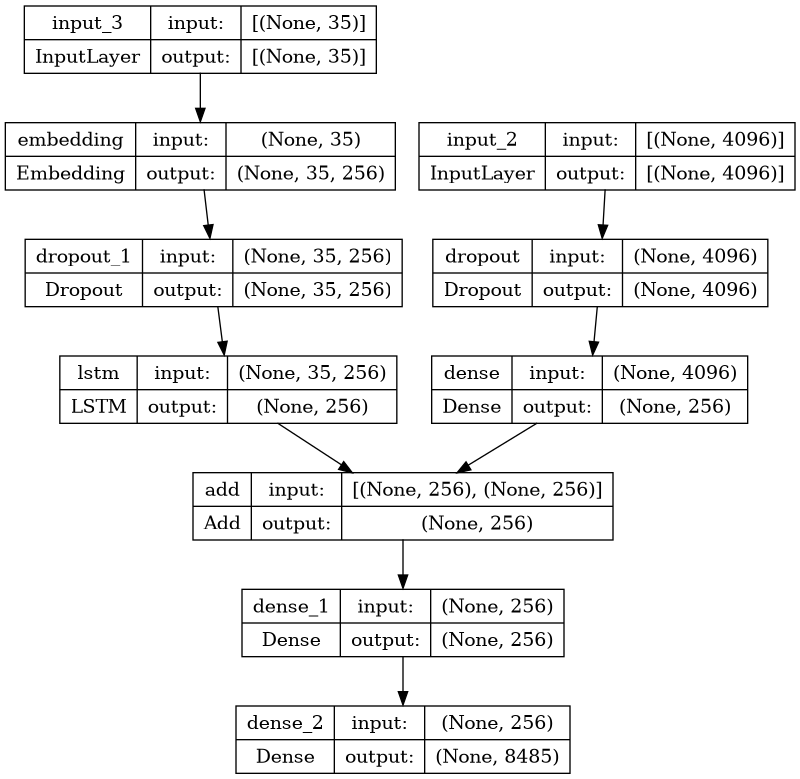

In [28]:
# image feature model
inputs1  = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256,activation='relu')(fe1)

# sequence feature layer
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero = True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2,se3])
decoder2 = Dense(256, activation ='relu')(decoder1)
outputs = Dense(vocab_size,activation="softmax")(decoder2)

model = Model(inputs=[inputs1,inputs2], outputs = outputs)
model.compile(loss="categorical_crossentropy", optimizer='adam')

# plot the model
plot_model(model,show_shapes=True)







In [29]:
# train the model
epochs = 20
batch_size = 64
steps = len(train)//batch_size
for i in range(epochs):
    #create data genarator
    generator = data_generator(train, mapping,features,tokenizer,max_length,vocab_size,batch_size)
    #fit for one epoch
    model.fit(generator, epochs=1,steps_per_epoch=steps,verbose=1)

113/113 [==============================] - 47s 418ms/step - loss: 2.2959


In [30]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Generate captions for the image

In [31]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index ==integer:
            return word
    return None

In [32]:
# generate captions for an image
def predict_caption(model,image,tokenizer,max_length):
    # add start tag for generation process
    in_text= 'startseq'
    # iterate over maxlength of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence= pad_sequences([sequence], max_length)
        # predict the next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text+=" "+word
        # stop if we reach end tag
        if word =="endseq":
            break
    return in_text

In [33]:
# VALIDATE WITH TEST DATA
from nltk.translate.bleu_score import corpus_bleu
actual,predicted = list(), list()
for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model,features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
    # calculate bleu score
print('BLEU-1:%f'%corpus_bleu(actual,predicted,weights= (1.0,0,0,0)))
print('BLEU-1:%f'%corpus_bleu(actual,predicted,weights= (0.5,0.5,0,0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1:0.560082
BLEU-1:0.331157


## Visualize the results


In [39]:
pip install Pillow

Note: you may need to restart the kernel to use updated packages.


In [48]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    
    image_id = image_name.split(".")[0]
    image_path = os.path.join(BASE_DIR,'Images',image_name)
    image = Image.open(image_path)
    captions  = mapping[image_id]
    print('-------------Actual------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer,max_length)
    print("-------------Predicted----------")
    print(y_pred)
    plt.imshow(image)


-------------Actual------------
startseq child in pink dress is climbing up set of stairs in an entry way endseq
startseq girl going into wooden building endseq
startseq little girl climbing into wooden playhouse endseq
startseq little girl climbing the stairs to her playhouse endseq
startseq little girl in pink dress going into wooden cabin endseq
-------------Predicted----------
startseq the girl is wearing green dress and playing in the yard endseq


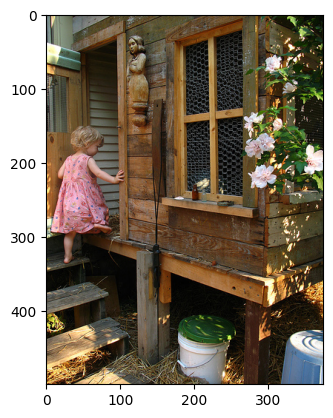

In [49]:
generate_caption("1000268201_693b08cb0e.jpg")